# Vehicle Tracking

## Feature Selection

In [1]:
# Develop training - test dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import glob


project_path = "/home/james/Documents/CarND-VehicleDetection-P5/"

# Import Images:
vehicles_folder = glob.glob(project_path + "Dataset/vehicles/*")
non_vehicles_folder = glob.glob(project_path + "Dataset/non-vehicles/*")

Vehicles = []
NotVehicles = []

# Read all vehicles
for subfolder in vehicles_folder:
    images = glob.glob(subfolder + "/*.png")
    for image in images:
        Vehicles.append(cv2.imread(image)) # Read Image as BGR, 0 - 255.
        
# Read all non-vehicles
for subfolder in non_vehicles_folder:
    images = glob.glob(subfolder + "/*.png")
    for image in images:
        img = cv2.imread(image)# Read Image as BGR, 0 - 255.
        NotVehicles.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB) ) #  Save images as RGB

vehsize = len(Vehicles)
notvehsize = len(NotVehicles)
total = vehsize + notvehsize
print(str(len(Vehicles)) + " Vehicles Images Imported. "+ str(round(100*vehsize/(total),2)) + "%")
print(str(len(NotVehicles)) + " Non Vehicle Images Imported. "+ str(round(100*notvehsize/(total),2)) + "%")


# Define Helper Function to Convert Images, input must be RGB
def ConvertColorSpace(img,cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        feature_image = np.copy(img) 
    return feature_image

8792 Vehicles Images Imported. 49.5%
8968 Non Vehicle Images Imported. 50.5%


### Color histogram

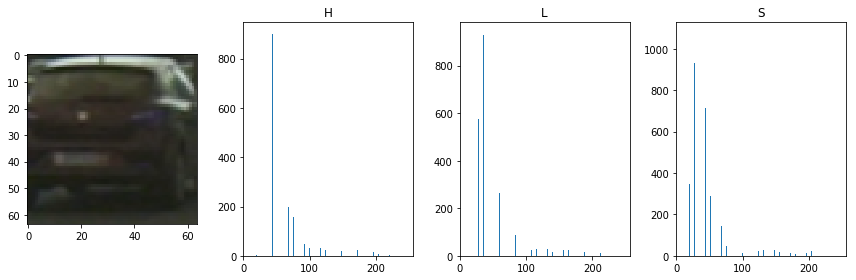

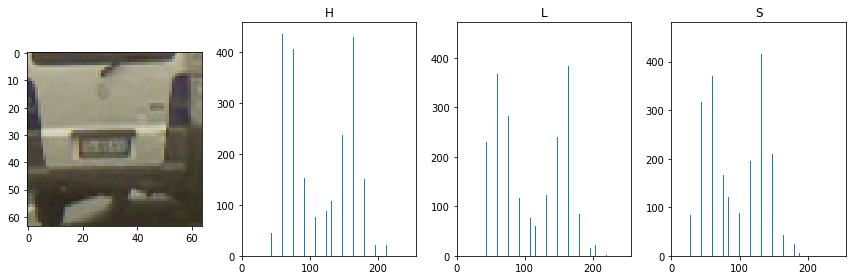

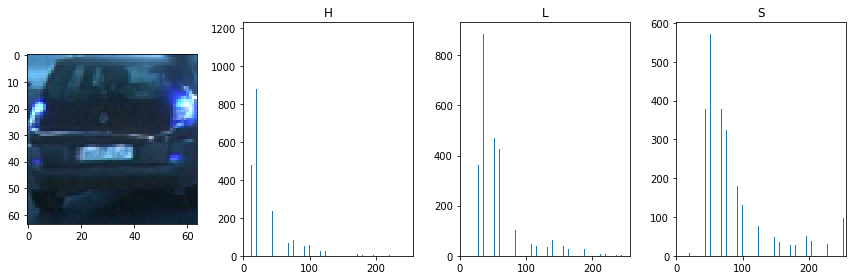

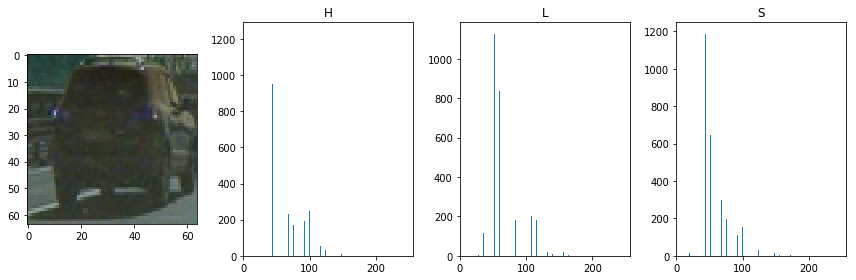

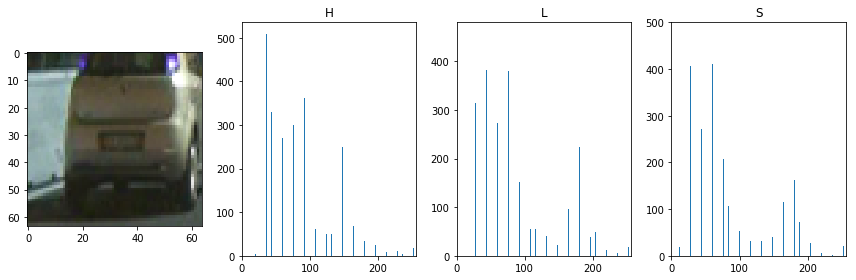

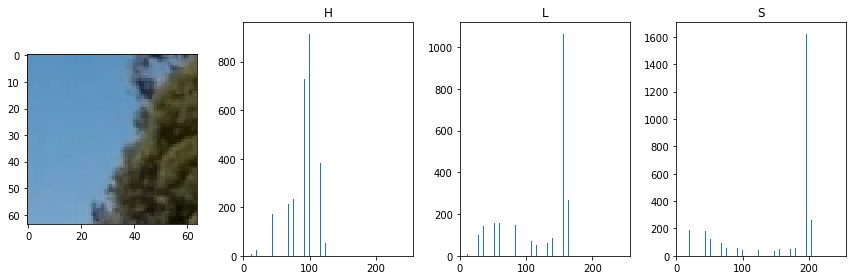

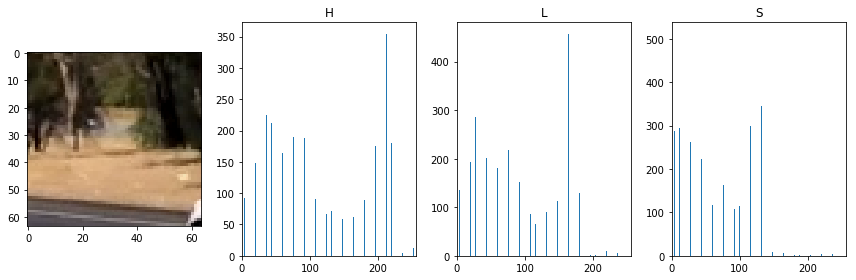

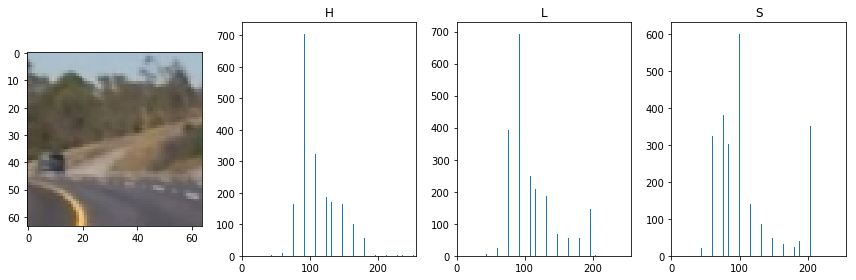

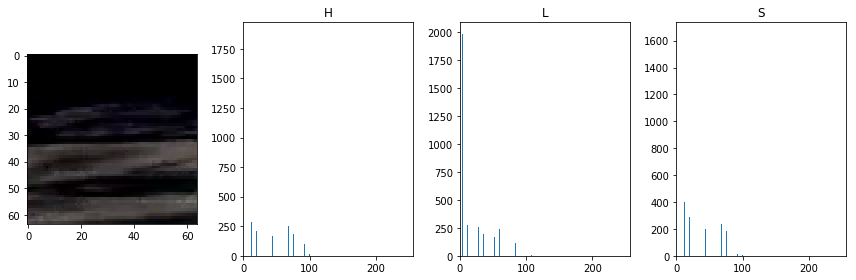

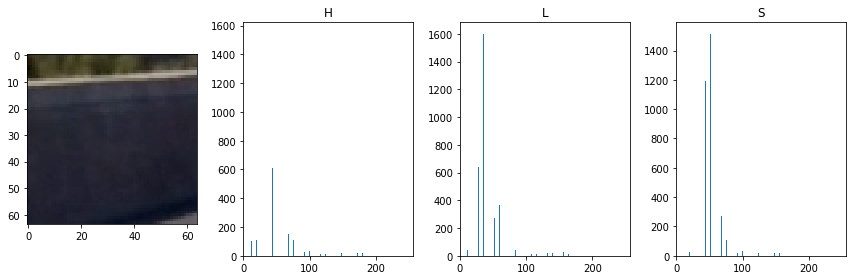

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins, bins_range):
    # Compute the histogram of the channels (1, 2, & 3) separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

def display_hist(img_list,cspace): 
    for image in img_list:
        feature_image =  ConvertColorSpace(image,cspace)
        c1, c2, c3, bincen, feature_vec = color_hist(feature_image, nbins=32, bins_range=(0, 256))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.imshow(image)    
        plt.subplot(1,4,2)
        plt.bar(bincen, c1[0])
        plt.xlim(0, 256)
        plt.title('H')
        plt.subplot(1,4,3)
        plt.bar(bincen, c2[0])
        plt.xlim(0, 256)
        plt.title('L')
        plt.subplot(1,4,4)
        plt.bar(bincen, c3[0])
        plt.xlim(0, 256)
        plt.title('S')
        fig.tight_layout()
        
# Test color_hist:

# get random n vehicle images
n=5
x = np.random.randint(0, vehsize-n)
images_vehicle= Vehicles [x: x+n]
images_nonvehicle = NotVehicles[x: x+n]

display_hist(images_vehicle,'RGB')
display_hist(images_nonvehicle,'RGB')

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size, gray):
    # Use cv2.resize().ravel() to create the feature vector
    if(gray):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return cv2.resize(img, size).ravel() 
    else:
        return cv2.resize(img, size).ravel() 

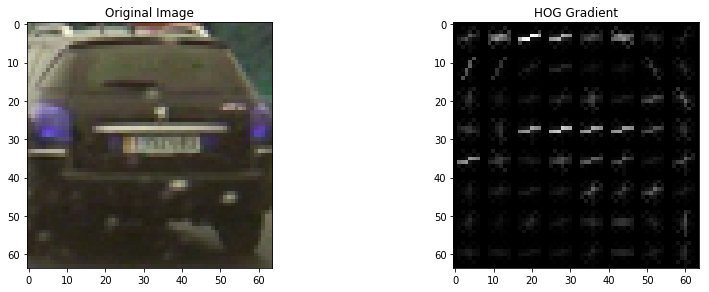

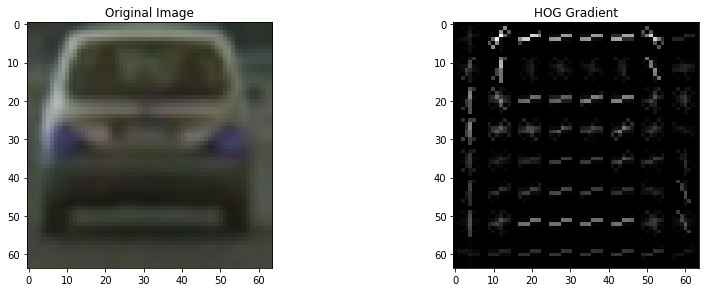

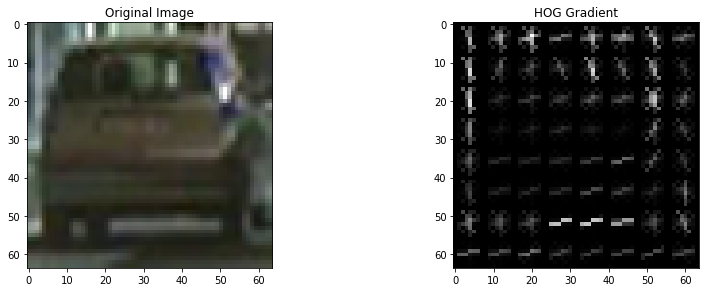

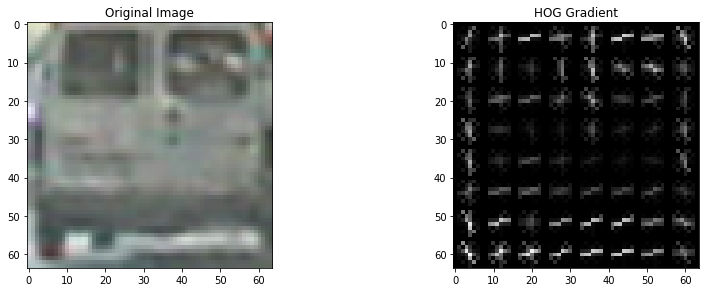

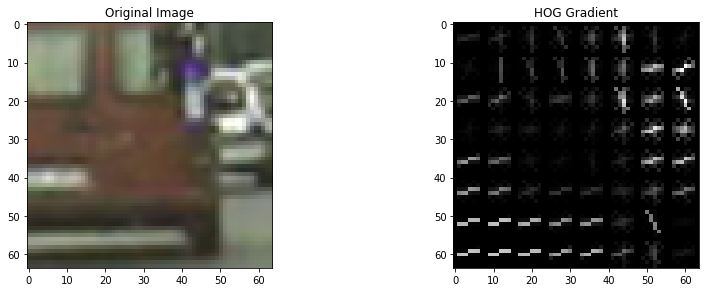

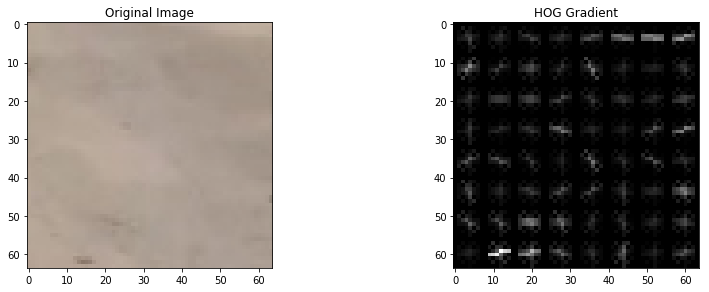

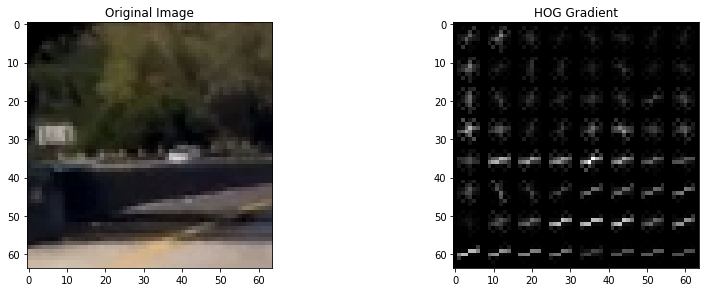

In [17]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Testing HOG Feature Extraction:

cspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# get random n vehicle images
n=5
x = np.random.randint(0, vehsize-n)
images_car= Vehicles [x: x+ n]
images_nocar = NotVehicles[x: x+2]
images_list = images_car + images_nocar

for img in images_list:
    feature_image =  ConvertColorSpace(img,cspace)    
    
    f_vec, image_hog = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, 
                        True,True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(feature_image)
    ax1.set_title('Original Image' )
    ax2.imshow(image_hog,cmap = 'gray')
    ax2.set_title('HOG Gradient')

In [18]:
def extract_features(imgs, cspace, spatial_size,hist_bins, hist_range,orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    
    # Create lists to append feature vectors to
    spatial_features = []
    hist_features = []
    hog_features = []
    features = []   
    for image in imgs:
        # Convert image to given color space
        img_converted = ConvertColorSpace(image,cspace) 
        
        #Generate pixel value histogram features
        c1, c2, c3, bincen, hist_features = color_hist(img_converted, hist_bins, hist_range)
        
        # Spatial binning features           
        spatial_features = bin_spatial(img_converted,spatial_size,False)
        
        # HOG Extraction
        #hog_features = get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
        
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    return features

## Classification

In [21]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import time

# Extract features from vehicle images:
print ("Generating feature vectors...")
t=time.time()

histbin = 32
spatial = 32
colspace = 'HSV'

cspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

car_features = extract_features(Vehicles, colspace, (spatial, spatial), histbin, (0, 256),
                               orient, pix_per_cell, cell_per_block, hog_channel)
notcar_features = extract_features(NotVehicles, colspace, (spatial, spatial), histbin, (0, 256),
                               orient, pix_per_cell, cell_per_block, hog_channel)
t2 = time.time()
print()
# Create an array stack of feature vectors

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print ("Done!", round(t2-t, 5), 'Seconds to generate features')
print('Feature Vector Size = ' , X.shape)
print('Label Vector Size = ', y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Initialize classifier
print("\nTraining classifier...")
#svc = svm.SVC(kernel = 'linear', C = 1.0, gamma = 'auto')
svc = svm.LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(100*svc.score(X_test, y_test), 2),"%")
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('\nMy SVC predicts:\t', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels:\t', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Generating feature vectors...

Done! 6.13024 Seconds to generate features
Feature Vector Size =  (17760, 3168)
Label Vector Size =  (17760,)

Training classifier...
11.63 Seconds to train SVC...
Test Accuracy of SVC =  93.19 %

My SVC predicts:	 [0. 1. 0. 0. 0. 0. 1. 1. 1. 0.]
For these 10 labels:	 [0. 1. 1. 0. 0. 0. 1. 1. 1. 0.]
0.0008 Seconds to predict 10 labels with SVC


## Vehicle Tracking

### Develop Tracking Boxes

In [23]:
# Function that draws boxes bboxes on img with color and thickness
def draw_boxes(img, bboxes, color, thick):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

In [43]:
#Generate the boxes to be used in sliding window approach
def slide_window(img, x_start_stop, y_start_stop, 
                    xy_window, xy_overlap):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # TODO : Compute 4 layers of boxes 

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


(720, 1280, 3)


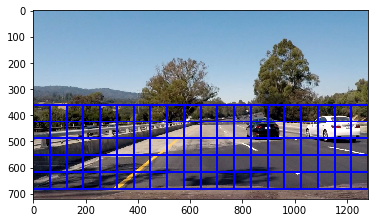

In [50]:
# Restrict serach boundary to bottom of image where vehicles are likely

image_window = cv2.imread(project_path + "test_images/" + "test4.jpg")
image_window = cv2.cvtColor(image_window,cv2.COLOR_BGR2RGB)

print (image_window.shape)
windows = slide_window(image_window, [0, image_window.shape[1]], [int(image_window.shape[0]*0.5),
                    image_window.shape[0]],(128, 128), (0.5, 0.5))
                       
window_img = draw_boxes(image_window, windows,(0, 0, 255), 6)                    
plt.imshow(window_img)